In [1]:
%pylab inline
import os
import seaborn as sns
import pickle as pkl
pal = sns.color_palette('Blues')
sns.set_context("paper", font_scale=1.5)
sns.set_style("ticks")
#sns.set(color_codes=True)
import pandas as pd
import salem
import pyproj
import numpy as np
from scipy.interpolate import griddata
from eod import trmm, msg
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy

Populating the interactive namespace from numpy and matplotlib


In [2]:
dic = pkl.load( open ('/users/global/cornkle/C_paper/wavelet/saves/bulk_10big.p', 'rb')) #MSG_TRMM_temp_pcp_300px2004-2013_new.p', 'rb'))

In [4]:
p=np.array(dic['pmax']) # 98th perc per MCS
t=np.array(dic['tmin'])  #mean T
clat = np.array(dic['clat'])
area = np.array(dic['area'])*25
isfin = np.array(dic['isfin'])
po30 = np.array(dic['po30'])
lonfin = np.array(dic['lonisfin'])
latfin = np.array(dic['latisfin'])
lon30 = np.array(dic['lon30'])
lat30 = np.array(dic['lat30'])
perc = np.array(dic['pperc'])
clat = np.array(dic['clat'])
hour = np.array(dic['hour'])
print('Number MCSs:', p.size)
print(area.size, lat30.size, po30.size)
print(np.sum(area>15000))

Number MCSs: 22346
22346 41170 22346
7248


In [5]:
np.percentile(perc[np.isfinite(perc)],99)

29.497689990519589

In [6]:
print(np.sum(po30))
print(area.min(), area.max())
print(p.min(), p.max())
print(lon30.min(), lon30.max())
print(lat30.min(), lat30.max())

41170
125 4511175
0.0 225.068606908
-17.5100571334 30.318985839
3.95749758572 20.426628954


In [7]:
ll=list(range(4,25,3))
dirr = []
hours = []
#for name in ll:
#    dirr[name]=[]

In [8]:
for ids, l in enumerate(ll):
    if l==4:
        continue
    print(ll[ids-1], l)    
    pos = np.where((clat<l) & (clat>=ll[ids-1]) & ((hour>=21) ^ (hour<6)))
    if len(pos[0]) == 0:
        dirr.append(np.nan)        
    else:    
        dirr.append(np.percentile(perc[pos], 99))
        

4 7
7 10
10 13
13 16
16 19
19 22


In [52]:
# make a salem grid
proj = pyproj.Proj('+proj=merc +lat_0=0. +lon_0=0.')
# Transform lon, lats to the mercator projection
x, y = pyproj.transform(salem.wgs84, proj,[-19, 30], [3,21.5])
# take the min and max
xmax, xmin = np.max(x), np.min(x)
ymax, ymin = np.max(y), np.min(y)
# Count the number of pixels
dx = 5000
nx, r = divmod(xmax - xmin, dx)
ny, r = divmod(ymax - ymin, dx)
# Here one could add + 1 to be sure that the last pixel is always included
grid = salem.Grid(nxny=(nx, ny), dxdy=(dx, dx), ll_corner=(xmin, ymin), proj=proj)

In [53]:
print(nx/10, ny/10)

109.0 42.0


In [54]:
grid50 = grid.regrid(factor=0.1)
lon50, lat50 = grid50.ll_coordinates

In [55]:
grid50.nx

109

In [56]:
lon, lat = grid.ll_coordinates
xi, yi = grid.ij_coordinates

In [57]:
po30_arr = np.zeros_like(lon)
isfin_arr = np.zeros_like(lon)
pmax_arr = np.zeros_like(lon)
print(po30_arr.shape)

(420, 1090)


In [58]:
for lo3, la3 in zip(lon30,lat30):
    try:
        xm, ym = grid.transform(lo3, la3, crs=salem.wgs84)
        po30_arr[int(np.round(ym)), int(np.round(xm))]+=1
    except IndexError:
        continue
for lonf, latf in zip(lonfin,latfin):   
    try:
        xm, ym = grid.transform(lonf, latf, crs=salem.wgs84)
        isfin_arr[int(np.round(ym)), int(np.round(xm))]+=1
    except IndexError:
        continue    

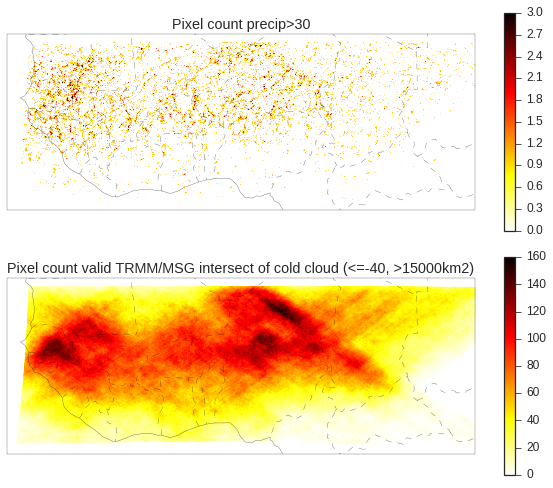

In [59]:
path = '/users/global/cornkle/C_paper/wavelet/figs/'
fig = plt.figure(figsize=(9,7), dpi=400)
ax = fig.add_subplot(211, projection=ccrs.PlateCarree())

plt.imshow(po30_arr, extent=(lon.min(), lon.max(), lat.min(), lat.max()), clim=(0,3), transform=ccrs.PlateCarree(), cmap='hot_r')
#plt.contourf(lon, lat, po30_arr, transform=ccrs.PlateCarree(), cmap='viridis_r', levels=np.arange(0,3,0.5) )
ax.coastlines()
plt.colorbar()
plt.title('Pixel count precip>30')
ax.add_feature(cartopy.feature.BORDERS, linestyle='--')

ax1 = fig.add_subplot(212, projection=ccrs.PlateCarree())
plt.imshow(isfin_arr, extent=(lon.min(), lon.max(), lat.min(), lat.max()), transform=ccrs.PlateCarree(), cmap='hot_r')
#plt.contourf(lon, lat, po30_arr, transform=ccrs.PlateCarree(), cmap='viridis_r', levels=np.arange(0,3,0.5) )
ax1.coastlines()
plt.colorbar()
plt.title('Pixel count valid TRMM/MSG intersect of cold cloud (<=-40, >15000km2)')
ax1.add_feature(cartopy.feature.BORDERS, linestyle='--')

plt.tight_layout()
#plt.savefig(path+'map_check.png')
plt.show()

In [60]:
def shrink(data, rows, cols):
    return data.reshape(rows, np.int(data.shape[0]/rows), cols, np.int(data.shape[1]/cols)).sum(axis=1).sum(axis=2)

In [61]:
coarse = shrink(po30_arr/isfin_arr*100, grid50.ny, grid50.nx)

In [62]:
coarse2 = shrink(po30_arr/np.sum(isfin_arr)*100, grid50.ny, grid50.nx)

In [63]:
coarse3 = shrink(po30_arr, grid50.ny, grid50.nx)

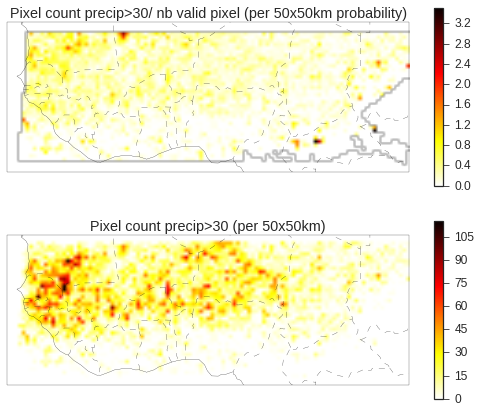

In [64]:
#%matplotlib
path = '/users/global/cornkle/C_paper/wavelet/figs/'
fig = plt.figure(figsize=(9,7), dpi=400)
ax = fig.add_subplot(211, projection=ccrs.PlateCarree())

plt.imshow(coarse/100, extent=(lon50.min(), lon50.max(), lat50.min(), lat50.max()), clim=(0,3.5), transform=ccrs.PlateCarree(), cmap='hot_r')
#plt.contourf(lon, lat, po30_arr, transform=ccrs.PlateCarree(), cmap='viridis_r', levels=np.arange(0,3,0.5) )
ax.coastlines()
plt.colorbar()
plt.title('Pixel count precip>30/ nb valid pixel (per 50x50km probability)')
ax.add_feature(cartopy.feature.BORDERS, linestyle='--')

ax = fig.add_subplot(212, projection=ccrs.PlateCarree())
plt.imshow(coarse3, extent=(lon50.min(), lon50.max(), lat50.min(), lat50.max()), transform=ccrs.PlateCarree(), cmap='hot_r')
#plt.contourf(lon, lat, po30_arr, transform=ccrs.PlateCarree(), cmap='viridis_r', levels=np.arange(0,3,0.5) )
ax.coastlines()
plt.colorbar()
plt.title('Pixel count precip>30 (per 50x50km)')
ax.add_feature(cartopy.feature.BORDERS, linestyle='--')

#plt.tight_layout()
#plt.savefig(path+'50km_map_prob.png')
